In [3]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

fetch_housing_data()
df = load_housing_data()

In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


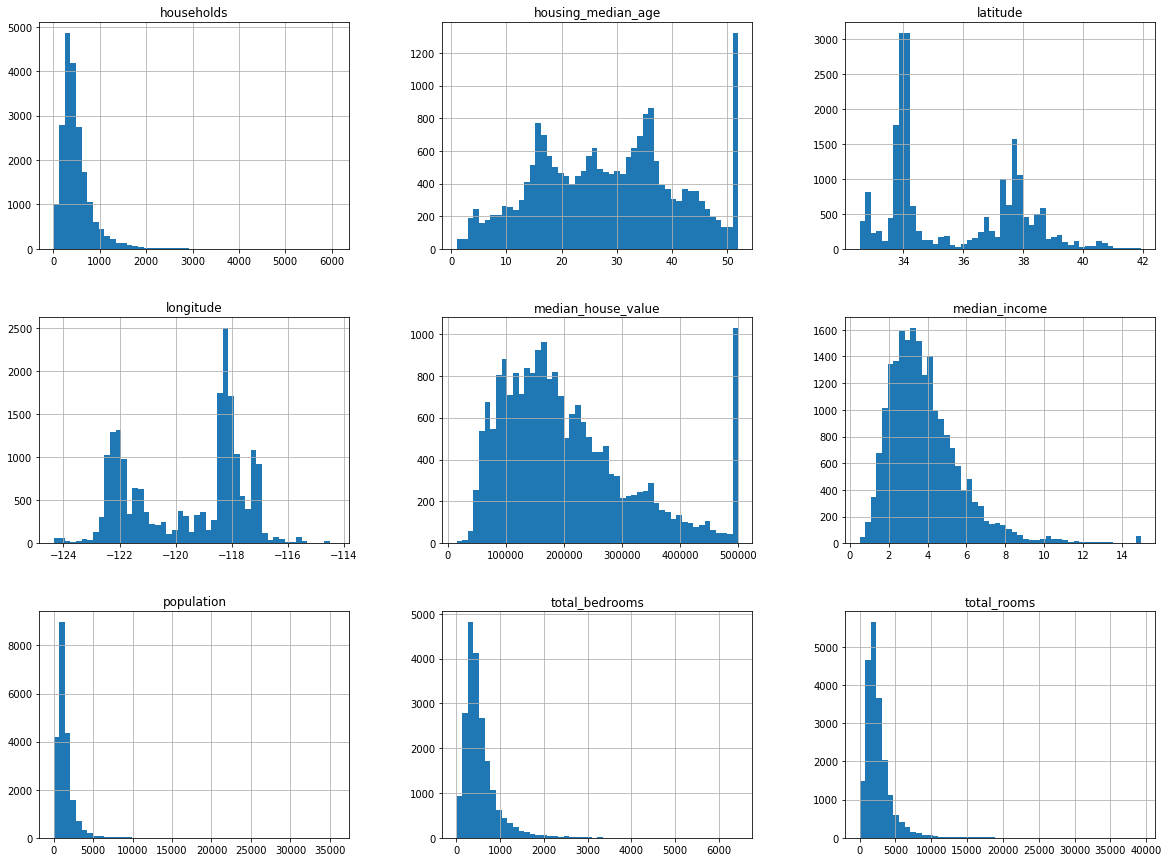

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20, 15))
plt.show()

In [8]:
import numpy as np

# version 1 of the split_train_test algorithm. issues with effectiveness after updating the dataset
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

# then we would use it like this
train_set, test_set = split_train_test(df, 0.2)

#version 2 of split_train_test algorithm. data is not stratified (which is important for small datasets)    
import hashlib 

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

# version 3. Scikit learn has some good libraries. Still not straitified (but shorter than last two)
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

# version 4. did some stratification first and then ran sklearn stratification train_test split
# the reason we do stratification is so that we can have proper representation of all the different population
# kinds that we're training on. in this case, one of the important population attributes is the median income
# without proper representation of all people's abilities to buy houses, we are not training an accurate 
# model
df["income_cat"] = np.ceil(df["median_income"] / 1.5)
df["income_cat"].where(df["income_cat"] < 5, 5.0, inplace=True)

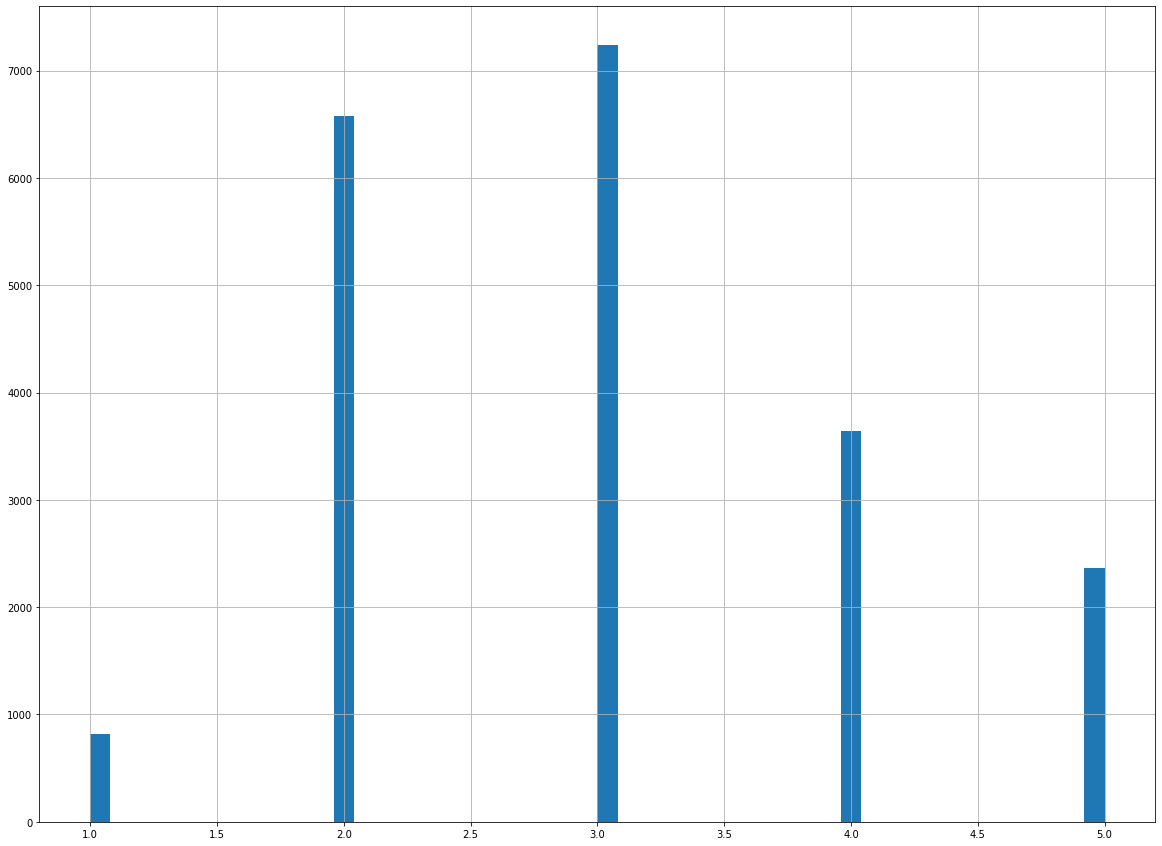

In [9]:
#result of stratification
df["income_cat"].hist(bins=50, figsize=(20, 15))
plt.show()

In [10]:
# Review: Median income is very important piece of data in that 
# it has a big say in what the ML Model looks like. Therefore, should prioritize median income representation
# of population (in other words, all median incomes should have proper representation in test data)
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
    
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [11]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
    
# Dropped "income cat" as a column, error below is because I 
# (accidentally) tried doing it twice

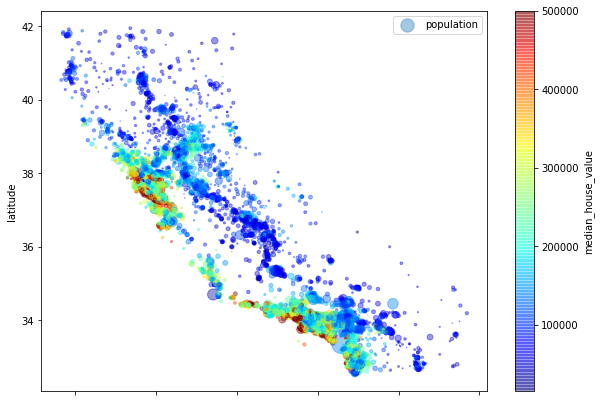

In [12]:
explore_df = strat_train_set.copy()
explore_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=explore_df["population"]/100,
               label="population", figsize=(10, 7), c="median_house_value", cmap=plt.get_cmap("jet"), 
               colorbar=True)
plt.legend()

In [13]:
corr_matrix = explore_df.corr()

#Correlation between median housing value and other attributes
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f26c1abca90>,
      dtype=object)

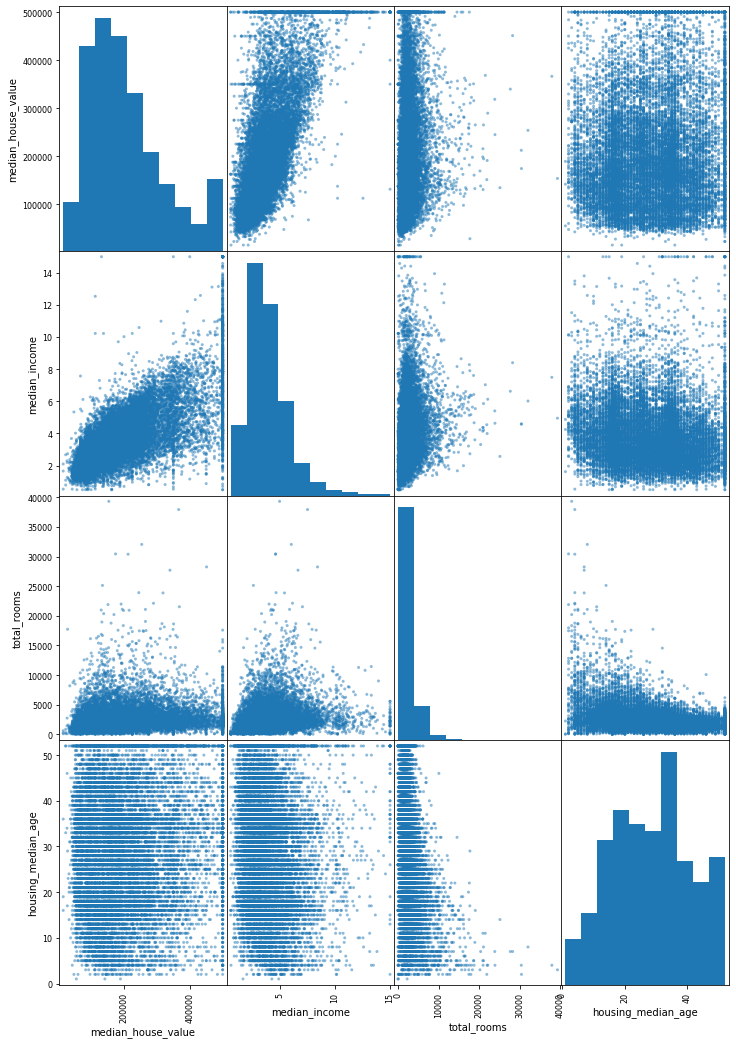

In [14]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(explore_df[attributes], figsize=(12,18))

In [15]:
explore_df["rooms_per_household"] = explore_df["total_rooms"] / explore_df["households"]
explore_df["bedrooms_per_room"] = explore_df["total_bedrooms"] / explore_df["total_rooms"]
explore_df["population_per_household"] = explore_df["population"] / explore_df["households"]

In [16]:
corr_matrix = explore_df.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [17]:
# Getting a clean version of the training set
df = strat_train_set.drop("median_house_value", axis=1)
df_labels = strat_train_set["median_house_value"].copy()

In [18]:
from sklearn.impute import SimpleImputer as Imputer

imputer = Imputer(strategy="median")
df_num = df.drop("ocean_proximity", axis=1)
imputer.fit(df_num)
# modifies training set AND returns NumPy array with modified features
X = imputer.transform(df_num)
# put it back into a dataframe:
df_tr = pd.DataFrame(X, columns=df_num.columns)
df_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [19]:
# have to deal with text attributes; ml models prefer numbers
df_cat = df[["ocean_proximity"]]
df_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [20]:
try: 
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    from future_encoders import OrdinalEncoder

In [21]:
ordinal_encoder = OrdinalEncoder()
df_cat_encoded = ordinal_encoder.fit_transform(df_cat)
df_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [22]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [23]:
# one-hot encoding. I understand why we're doing it, I don't understand why this method is 
# particularly effective
# edit: every kind of encoded type gets its own vector, and that vector is basically a list of "features"
# in the hypothesis. Its effectively the same thing as having a feature per type of category that only has 
# the number 1 as the X input (but in a different position than the previous "feature")
# second edit: apprently onehot encoder now supports straight up text attributes, so you don't need to
# factorize (or, in the new case, OrdinalEncoder)
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder

cat_encoder = OneHotEncoder()
df_cat_1hot = cat_encoder.fit_transform(df_cat)
df_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin
# custom transformer, as an example
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix] # syntax : means all rows, rooms_ix is
        #specifically column number rooms_ix (points to column with the rooms feature)
        population_per_household = X[:, bedrooms_ix] / X[:, rooms_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
df_extra_atrribs = attr_adder.transform(df.values)
# automating data preparation helps control which parts of data prep get tossed into the model and 
# which don't, which can help with model experimentation and tweaking

In [25]:
# small pipeline to help with the order of the steps
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

df_num_tr = num_pipeline.fit_transform(df_num)

In [26]:
# new column transformer, does it the way exactly how it would have the old way (with the Pipeline class)
# and more friendly with other pipelines
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer

In [27]:
num_attribs = list(df_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

In [28]:
# "inline" cat pipeline
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

df_prepared = full_pipeline.fit_transform(df)

In [29]:
print(df_prepared.shape) # perfect!
print(df_labels.shape)

(16512, 16)
(16512,)


In [30]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(df_prepared, df_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [31]:
some_data = df.iloc[:5]
some_labels = df_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions", lin_reg.predict(some_data_prepared))

Predictions [210528.01750105 317824.00920324 210815.82440675  59307.5245779
 189946.78983305]


In [32]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [33]:
from sklearn.metrics import mean_squared_error
df_predictions = lin_reg.predict(df_prepared)
lin_mse = mean_squared_error(df_labels, df_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68635.59352516982

In [34]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(df_prepared, df_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [35]:
df_predictions = tree_reg.predict(df_prepared)
tree_mse = mean_squared_error(df_labels, df_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [36]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, df_prepared, df_labels, scoring = "neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [37]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean()),
    print("Standard Deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70504.44106387 65321.0942038  73901.1139106  69777.89433383
 70809.55998501 73103.74164546 71358.88898625 71076.99231382
 69664.63034989 68405.86123398]
Mean: 70392.42180265072
Standard Deviation: 2276.4783041954206


In [38]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(df_prepared, df_labels)

df_predictions = forest_reg.predict(df_prepared)
forest_mse = mean_squared_error(df_labels, df_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18619.58843757942

In [39]:
scores = cross_val_score(forest_reg, df_prepared, df_labels, scoring = "neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [48427.33252019 46138.18766892 49396.2429903  50605.25774083
 49385.02233147 52918.32728125 48431.37263555 50912.86129723
 51270.63152542 49688.04799121]
Mean: 49717.328398236554
Standard Deviation: 1766.897346669383


In [40]:
# example of how to use joblib using the tree regressor and forest regressor
from sklearn.externals import joblib

joblib.dump(tree_reg, "tree_reg.pkl")
joblib.dump(forest_reg, "forest_reg.pkl")
# ... and then later
tree_reg_loaded = joblib.load("tree_reg.pkl")
forest_reg_loaded = joblib.load("forest_reg.pkl")

/home/spoderman/Documents/ml/env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [41]:
from sklearn.model_selection import GridSearchCV

param_grid=[
    {'n_estimators':[3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators':[3, 10], 'max_features':[2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(df_prepared, df_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],
             

In [42]:
grid_search.best_params_
# if it would have been the case that 8 and 30 were the best params, then it might be worth
# exploring bigger numbers in the hyperparameters

{'max_features': 8, 'n_estimators': 30}

In [43]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [44]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

66707.66421999226 {'max_features': 2, 'n_estimators': 3}
57980.23034561968 {'max_features': 2, 'n_estimators': 10}
55709.53885161491 {'max_features': 2, 'n_estimators': 30}
62591.70403475965 {'max_features': 4, 'n_estimators': 3}
55454.39118842854 {'max_features': 4, 'n_estimators': 10}
52765.91810568197 {'max_features': 4, 'n_estimators': 30}
61272.444120010856 {'max_features': 6, 'n_estimators': 3}
54495.534503367955 {'max_features': 6, 'n_estimators': 10}
51617.415334981764 {'max_features': 6, 'n_estimators': 30}
60908.361433629485 {'max_features': 8, 'n_estimators': 3}
53367.926172907275 {'max_features': 8, 'n_estimators': 10}
51469.63022249116 {'max_features': 8, 'n_estimators': 30}
65324.568212380604 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
56924.77172971128 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
62093.64841143683 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
54447.789378025824 {'bootstrap': False, 'max_features': 3, 'n_estimato

In [45]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([9.83853560e-02, 8.13319665e-02, 4.49921107e-02, 2.03005074e-02,
       2.11188560e-02, 2.89572404e-02, 1.89440531e-02, 3.74581793e-01,
       4.27629771e-02, 3.91338412e-02, 4.54249094e-02, 6.22562043e-03,
       1.70672439e-01, 5.08634200e-05, 1.78295300e-03, 5.33451376e-03])

In [48]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3745817930546307, 'median_income'),
 (0.17067243852927355, 'INLAND'),
 (0.0983853560252155, 'longitude'),
 (0.0813319665175169, 'latitude'),
 (0.045424909352333016, 'bedrooms_per_room'),
 (0.04499211071681762, 'housing_median_age'),
 (0.042762977055158476, 'rooms_per_hhold'),
 (0.03913384117284487, 'pop_per_hhold'),
 (0.028957240436999588, 'population'),
 (0.02111885596883128, 'total_bedrooms'),
 (0.020300507433252343, 'total_rooms'),
 (0.018944053128441503, 'households'),
 (0.006225620428747708, '<1H OCEAN'),
 (0.00533451376015137, 'NEAR OCEAN'),
 (0.0017829529998156539, 'NEAR BAY'),
 (5.086341996998473e-05, 'ISLAND')]

In [49]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) 

In [50]:
final_rmse

48124.26482372132

In [52]:
from sklearn.svm import SVR

support_vector = SVR()
df_prepared = full_pipeline.transform(df)
param_grid=[
    {'kernel': ["linear"], 'C':[2, 4, 6, 8]}, # best c parameter is maximum, maybe try larger ones
    {'kernel': ["rbf"], 'C': [2, 4, 6, 8], 'gamma':[10, 15, 20, 25, 30]}
]

grid_search = GridSearchCV(support_vector, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(df_prepared, df_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [2, 4, 6, 8], 'kernel': ['linear']},
                         {'C': [2, 4, 6, 8], 'gamma': [10, 15, 20, 25, 30],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [53]:
svr_best = grid_search.best_estimator_

def printHyperparameterScores(grid_search):
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(np.sqrt(-mean_score), params)
        
printHyperparameterScores(grid_search)

106849.11113743632 {'C': 2, 'kernel': 'linear'}
98322.08130569589 {'C': 4, 'kernel': 'linear'}
92315.74763318102 {'C': 6, 'kernel': 'linear'}
87823.38786548792 {'C': 8, 'kernel': 'linear'}
118922.25014424759 {'C': 2, 'gamma': 10, 'kernel': 'rbf'}
118922.84765075648 {'C': 2, 'gamma': 15, 'kernel': 'rbf'}
118923.0299412183 {'C': 2, 'gamma': 20, 'kernel': 'rbf'}
118923.10801021801 {'C': 2, 'gamma': 25, 'kernel': 'rbf'}
118923.1457404577 {'C': 2, 'gamma': 30, 'kernel': 'rbf'}
118921.327574047 {'C': 4, 'gamma': 10, 'kernel': 'rbf'}
118922.52719019304 {'C': 4, 'gamma': 15, 'kernel': 'rbf'}
118922.8927055026 {'C': 4, 'gamma': 20, 'kernel': 'rbf'}
118923.04798051085 {'C': 4, 'gamma': 25, 'kernel': 'rbf'}
118923.12343937339 {'C': 4, 'gamma': 30, 'kernel': 'rbf'}
118920.40481589478 {'C': 6, 'gamma': 10, 'kernel': 'rbf'}
118922.20675897905 {'C': 6, 'gamma': 15, 'kernel': 'rbf'}
118922.75548269066 {'C': 6, 'gamma': 20, 'kernel': 'rbf'}
118922.98795940749 {'C': 6, 'gamma': 25, 'kernel': 'rbf'}
1189

In [54]:
from sklearn.model_selection import RandomizedSearchCV

param_grid=[
    {'n_estimators':[3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators':[3, 10], 'max_features':[2, 3, 4]}
]

rand_search = RandomizedSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error")

In [55]:
rand_search.fit(df_prepared, df_labels)

AttributeError: 'list' object has no attribute 'values'